In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/MyDrive/iss/PRS/PM/COVID-CT-Mask-Net-master')
!ls

import sys
sys.path.append('/content/gdrive/MyDrive/iss/PRS/PM/vision/references/detection')

Mounted at /content/gdrive
config_classifier.py	   README.md
config_segmentation.py	   requirements.txt
covid_data		   saved_models
datasets		   saved_models1
eval_imgs		   test_split_segmentation.txt
evaluate_classifier.py	   train_classifier.py
evaluation_mean_ap.py	   train_segmentation.py
inference_segmentation.py  train_split_classification.txt
models			   train_split_segmentation.txt
plots			   Untitled0.ipynb
presentations		   Untitled1.ipynb
pretrained_models	   utils.py
__pycache__


In [2]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import numpy as np


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [3]:
model = get_model_instance_segmentation(2)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [4]:
import torch
model.load_state_dict(torch.load('../lung_mask_model.pth'))

<All keys matched successfully>

In [9]:
from PIL import Image
from torchvision import transforms

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

img_path = '../covid_data/cncb/train_large/CP_3835_5779_0008.png'
img = Image.open(img_path).convert("RGB")

t_ = transforms.Compose([transforms.ToTensor()])
img = np.array(img)
img = t_(img)

# put the model in evaluation mode
model.eval().to(device)
with torch.no_grad():
    prediction = model([img.to(device)])

In [7]:
print(prediction)

[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0'), 'masks': tensor([], device='cuda:0', size=(0, 1, 512, 512))}]


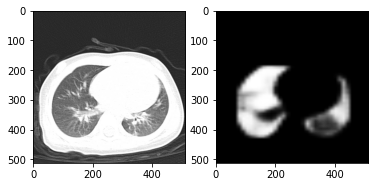

In [10]:
import matplotlib.pyplot as plt
import cv2

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img.mul(255).permute(1, 2, 0).byte().numpy(), cmap='gray')
ax[1].imshow(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy(), cmap='gray')
# mask = cv2.cvtColor(target['masks'].mul(255).permute(1, 2, 0).byte().numpy(), cv2.COLOR_GRAY2RGB)
# ax[2].imshow(mask, cmap='gray')

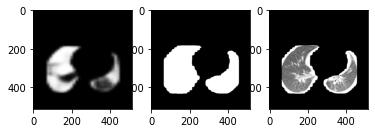

In [11]:
mask = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
kernel = np.ones((16,16), np.uint8)

mask2 = cv2.morphologyEx(np.uint8(mask), cv2.MORPH_CLOSE, kernel)

_, mask2 = cv2.threshold(mask, 2, 255, cv2.THRESH_BINARY)
mask2 = cv2.morphologyEx(np.uint8(mask2), cv2.MORPH_CLOSE, kernel)
mask2 = mask2/255

row_img = img.mul(255).permute(1, 2, 0).byte().numpy()
row_img = cv2.bitwise_and(row_img, row_img, mask=np.uint8(mask2))
fig, ax = plt.subplots(1, 3)
ax[0].imshow(mask, cmap='gray')
ax[1].imshow(mask2, cmap='gray')
ax[2].imshow(row_img, cmap='gray')

In [ ]:
import models.mask_net as mask_net
from models.mask_net.faster_rcnn import FastRCNNPredictor, TwoMLPHead
from models.mask_net.rpn import AnchorGenerator

from PIL import Image as PILImage

In [ ]:
s_features = 1024
n_c = 3
device = 'cuda'

covid_mask_net_args = {'num_classes': None, 'min_size': 512, 'max_size': 1024, 'box_detections_per_img': 256,
                        'box_nms_thresh': 0.75, 'box_score_thresh': -0.01, 'rpn_nms_thresh': 0.75}



if torch.cuda.is_available() and device == 'cuda':
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
# either 2+1 or 1+1 classes
ckpt = torch.load('pretrained_models/classification_model_both_classes.pth', map_location=device)

sizes = ckpt['anchor_generator'].sizes
aspect_ratios = ckpt['anchor_generator'].aspect_ratios
anchor_generator = AnchorGenerator(sizes, aspect_ratios)
# Faster R-CNN interfaces, masks not implemented at this stage
box_head = TwoMLPHead(in_channels=256*7*7, representation_size=128)
box_predictor = FastRCNNPredictor(in_channels=128, num_classes=n_c)
# Mask prediction is not necessary, keep it for future extensions
covid_mask_net_args['rpn_anchor_generator'] = anchor_generator
covid_mask_net_args['box_predictor'] = box_predictor
covid_mask_net_args['box_head'] = box_head
# representation size of the S classification module
# these should be provided in the config
covid_mask_net_args['s_representation_size'] = s_features

covid_mask_net_model = mask_net.fasterrcnn_resnet_fpn("resnet50", "1", **covid_mask_net_args)
covid_mask_net_model.load_state_dict(ckpt['model_weights'])
covid_mask_net_model.eval().to(device)


/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torchvision.models.detection.anchor_utils.AnchorGenerator' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, af

In [ ]:
im = PILImage.open('../covid_data/cncb/train_large/CP_726_3088_0118.png')
if im.mode != 'RGB':
    im = im.convert(mode='RGB')
# get rid of alpha channel
img = np.array(im)
# print(type(img[0][0][0]))

if img.shape[2] > 3:
    img = img[:, :, :3]

# img = row_img

t_ = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(512),
    transforms.ToTensor()])
img = t_(img)
if device == torch.device('cuda'):
    img = img.to(device)

out = covid_mask_net_model([img])

In [ ]:
print(out)

[{'final_scores': tensor([  4.9739,  -1.8217, -15.7522], device='cuda:0',
       grad_fn=<SqueezeBackward3>)}]
